In [1]:
import subprocess
import sys
sys.path.append("/Users/williamjenkins/Research/Code/TritonOA/")

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.special import hankel1

from TritonOA.env import env
from TritonOA.io import readwrite
from TritonOA.plotting import plotting

In [2]:
parameters = dict()

# Set Run Type =======================================================================
parameters['fullfield'] = True
parameters['TITLE'] = 'TestMFP'

# Define Geometry ====================================================================
parameters['NMEDIA'] = 1
parameters['ZB'] = 1000 # Bottom depth (m)
parameters['NZ'] = 1001 # Number of depth points
parameters['Z'] = np.linspace(0, parameters['ZB'], parameters['NZ']) # Depth vector (m)
parameters['RMAX'] = 10 # Maximum range (km)
parameters['NR'] = 10001 # Number of range points
parameters['R'] = np.linspace(0, parameters['RMAX'], parameters['NR']) # Range vector (km)
# parameters['X'] = np.arange(0, parameters['RMAX'], 0.001)  # <-------------------------------- ***
parameters['NMESH'] = 0

# Define Source/Receiver ============================================================
parameters['SD'] = 10.5 
# parameters['SR'] = 
parameters['NSD'] = 1
parameters['RD'] = parameters['Z']
parameters['NRD'] = len(parameters['RD'])
parameters['FREQ'] = 150

# Define Top Boundary =========================================================
parameters['TOPOPT'] = "NVF" # C = Linear SSP interp; V = Vacuum in upper halfspace; F = Freq-dep Attenuation (dB/kmHz)
parameters['SIGMA_TOP'] = 0 # RMS roughness (m)

# Define Sound Speed Profile ================================================
SSP_TYPE = "isospeed"
[parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, dC=50).items()]

# Define Bottom Boundary ======================================================
parameters['BOTOPT'] = "A" # A = Acousto-elastic halfspace
parameters['SIGMA_BOT'] = 0 # RMS roughness (m)
parameters['CPB'] = 2000 # P-wave speed (m/s)
parameters['CSB'] = 0 # S-wave speed (m/s)
parameters['RHOB'] = 2.0 # Density (kg/m3)
parameters['APB'] = 0.2 # P-wave attenuation (dB/kmHz)
parameters['ASB'] = 0 # S-wave attenuation (dB/kmHz)

# Phase Speed Limits ============================================================
parameters['CLOW'] = 0 # Lower phase speed limit (m/s)
parameters['CHIGH'] = parameters['CPB']  # Upper phase speed limit (m/s)

In [3]:
def build_env(parameters):
    ssp = env.SSPraw(
        parameters['Z'],
        parameters['CP'],
        parameters['CS'],
        parameters['RHO'],
        parameters['AP'],
        parameters['AS']
    )
    
    top = env.TopBndry(parameters['TOPOPT'])

    halfspace = env.HS(
        parameters['CPB'],
        parameters['CSB'],
        parameters['RHOB'],
        parameters['APB'],
        parameters['ASB']
    )

    bottom = env.BotBndry(parameters['BOTOPT'], halfspace)

    bdy = env.Bndry(top, bottom)
    
    depth = [0, parameters['ZB']]
    ssp_list = [ssp]
    NMESH = [parameters['NMESH']]
    sigma = [parameters['SIGMA_TOP'], parameters['SIGMA_BOT']] # Roughness at each layer; only affects attenuation (imag. part)
    ssp = env.SSP(
        ssp_list,
        depth,
        parameters['NMEDIA'],
        parameters['TOPOPT'],
        NMESH,
        sigma
    )

    cInt = env.cInt(parameters['CLOW'], parameters['CHIGH'])
    
    s = env.Source([parameters['SD']])
    r = env.Dom(parameters['R'], parameters['RD'])
    pos = env.Pos(s,r)
    
    pos.Nsd = parameters['NSD']
    pos.Nrd = parameters['NRD']

    readwrite.write_env(
        f"{parameters['TITLE']}.env",
        "KRAKEN",
        parameters['TITLE'],
        parameters['FREQ'],
        ssp,
        bdy,
        pos,
        [],
        cInt,
        parameters['RMAX']
    )
    
    envfil = f'{parameters["TITLE"]}.env'
    
    return pos, envfil


def run_kraken(parameters, fname=None, shdflag=False):
    pos, _ = build_env(parameters)
    retcode = subprocess.call(
        f'kraken.exe {parameters["TITLE"]}',
        shell=True,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    
    if shdflag:
        readwrite.write_fieldflp(parameters['TITLE'], 'R', pos)
        retcode = subprocess.call(
            f'field.exe {parameters["TITLE"]}',
            shell=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )

    return pos, retcode

In [4]:
_, _ = run_kraken(parameters, shdflag=True)

0


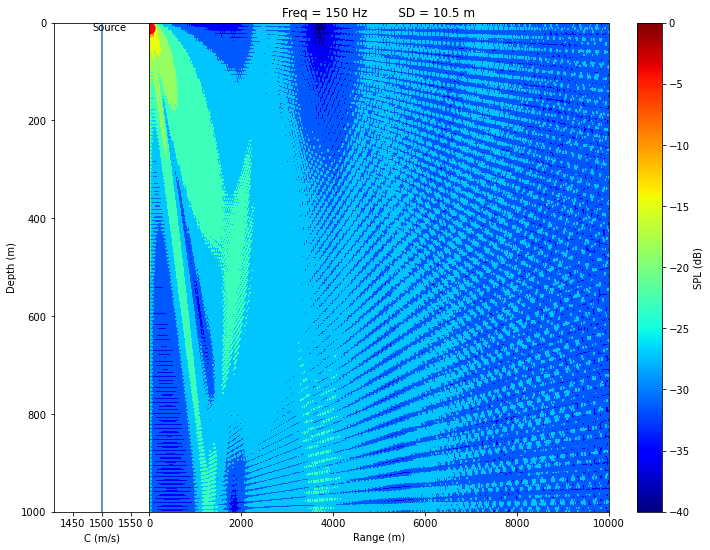

In [5]:
[x, x, x, x, pos, pressure_complex] = readwrite.read_shd(f"{parameters['TITLE']}.shd")

pressure = abs(pressure_complex)
pressure[pressure == 0] = 1e-30
plotting.plot_TL(pressure, pos, parameters, show=True)
plt.close()